I removed the Voigt profile 'baseline drift' in the background by fitting a quadratic to it manually. Should I put it back in? I think we get better fits without it.

I am also not working with x-axis data right now. Literally just using the 1d y-axis data.

# TODO
1. To extend it into a multi-class classification
2. automatic baseline removal for all samples
    (a) We take the points that are not the spectra, and use them to fit a quadratic curve.

Text(0.5, 1.0, '[0.]')

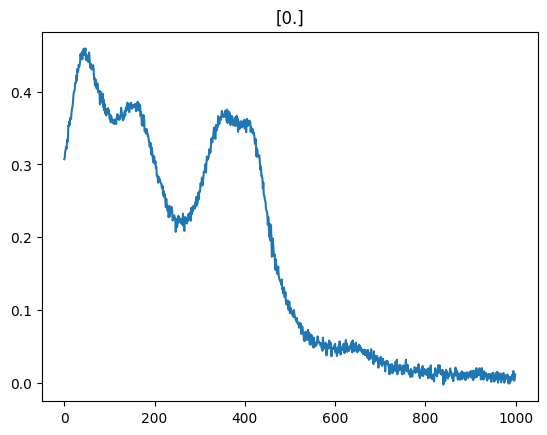

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

# Load synthetic datasets
X_class1 = np.loadtxt(
    "cnn_data/cnn_1_synthetic.csv", skiprows=1, delimiter=","
)  # Shape: (num_samples, 1000)
X_class2 = np.loadtxt(
    "cnn_data/cnn_0_synthetic.csv", skiprows=1, delimiter=","
)  # Shape: (num_samples, 1000)

# Create labels: Class 1 (label = 1) and Class 2 (label = 0)
y_class1 = np.ones((X_class1.shape[0], 1))
y_class2 = np.zeros((X_class2.shape[0], 1))

# Combine datasets
X = np.vstack([X_class1, X_class2])
y = np.vstack([y_class1, y_class2])

# Shuffle dataset
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

# Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
plt.plot(X[0])
plt.title(y[0])

Text(0.5, 1.0, '[1.]')

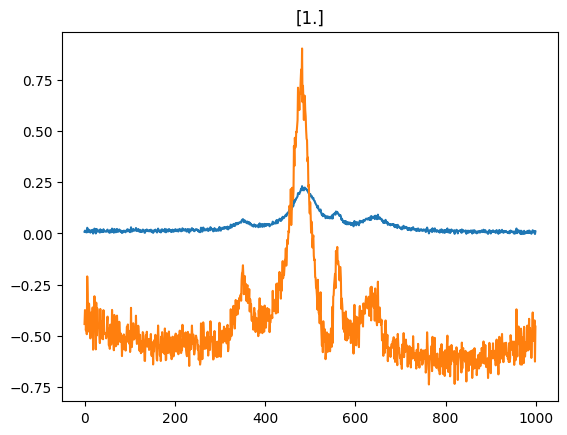

In [91]:
# normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # -1 to 1 scaling
plt.plot(X_train[1])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(X_train[1])
plt.title(y[1])

In [92]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Reshape the data for CNN input
X_train = X_train.reshape(X_train.shape[0], 1, 1000)
X_test = X_test.reshape(X_test.shape[0], 1, 1000)
# convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=64, kernel_size=4, stride=1, padding=1
        )
        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=1
        )
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2)  # Pooling size 3

        input_size = 1000  # New input size
        conv1_out = (input_size - 4 + 2) + 1  # Conv1 output size (padding=1)
        pool1_out = (conv1_out - 3) // 2 + 1  # Pool1 output size
        conv2_out = (pool1_out - 4 + 2) + 1  # Conv2 output size (padding=1)
        pool2_out = (conv2_out - 3) // 2 + 1  # Pool2 output size

        self.flattened_size = 128 * pool2_out

        self.fc1 = nn.Linear(
            self.flattened_size, 64
        )  # Adjust input size based on pooling
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Instantiate the model
model = CNN1D()
print(model)

CNN1D(
  (conv1): Conv1d(1, 64, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=31744, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [93]:
# train the model
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
    labels = torch.tensor(y_train, dtype=torch.float32).to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

/var/folders/cs/t7hq7xj94n13sr47pvj399n00000gn/T/ipykernel_7928/358435083.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
/var/folders/cs/t7hq7xj94n13sr47pvj399n00000gn/T/ipykernel_7928/358435083.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_train, dtype=torch.float32).to(device)


Epoch 1/10, Loss: 0.6956
Epoch 2/10, Loss: 0.2180
Epoch 3/10, Loss: 0.0971
Epoch 4/10, Loss: 0.0455
Epoch 5/10, Loss: 0.0095
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0011
Epoch 8/10, Loss: 0.0072
Epoch 9/10, Loss: 0.0063
Epoch 10/10, Loss: 0.0020


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model
def evaluate_model(model):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient computation needed
        outputs = model(X_test)  # Forward pass
        predictions = (
            outputs > 0.5
        ).float()  # Convert probabilities to binary (0 or 1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [95]:
evaluate_model(model)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0, 1.0)